# Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,10)

import scipy.stats as stats
import math
import seaborn as sns

# Download raw data and preprocess it

In [2]:
df = pd.read_csv('raw_data.csv')

In [3]:
df = df[df['participant._current_page_name'] == 'Final_page'].reset_index(drop=True) 
#choose only participants who finished all rounds

## Recode data from survey

In [4]:
data = df[['participant.code'
    ,'survey_and_risk_pref.1.player.age'
    ,'survey_and_risk_pref.1.player.gender'
   ,'survey_and_risk_pref.1.player.gpa'
   ,'survey_and_risk_pref.1.player.income'
   ,'survey_and_risk_pref.1.player.risk'
   ,'survey_and_risk_pref.1.player.cheat'
   ,'survey_and_risk_pref.1.player.cheat_opinion']]

data = data.rename({
    'participant.code':'id'
    ,'survey_and_risk_pref.1.player.age':'age'
    ,'survey_and_risk_pref.1.player.gender':'gender'
   ,'survey_and_risk_pref.1.player.gpa':'gpa'
   ,'survey_and_risk_pref.1.player.income':'income'
   ,'survey_and_risk_pref.1.player.risk':'subject_risk'
   ,'survey_and_risk_pref.1.player.cheat':'cheat_activity'
   ,'survey_and_risk_pref.1.player.cheat_opinion':'cheat_disagree'
}, axis=1)

income_list = []

for j in range(len(data)):
    person = data.iloc[j]
    i = 1
    
    if person['income'] == '<10 000 rubles':
        income_list.append(1)
    if person['income'] == '10 000 - 20 000 rubles':
        income_list.append(2)
    if person['income'] == '20 000 - 40 000 rubles':
        income_list.append(3)
    if person['income'] == '40 000 - 70 000 rubles':
        income_list.append(4)    
    if person['income'] == '70 000 - 100 000 rubles':
        income_list.append(5) 
    if person['income'] == '>100 000 rubles':
        income_list.append(6) 

## Holt-Laury task and set categories


In [5]:
#data onlu from Holt-Laury task
df1 = df[['survey_and_risk_pref.1.player.h1'
    ,'survey_and_risk_pref.1.player.h2'
    ,'survey_and_risk_pref.1.player.h3'
    ,'survey_and_risk_pref.1.player.h4'
    ,'survey_and_risk_pref.1.player.h5'
    ,'survey_and_risk_pref.1.player.h6'
    ,'survey_and_risk_pref.1.player.h7'
    ,'survey_and_risk_pref.1.player.h8'
    ,'survey_and_risk_pref.1.player.h9'
    ,'survey_and_risk_pref.1.player.h10']]

list_h = ['survey_and_risk_pref.1.player.h1'
    ,'survey_and_risk_pref.1.player.h2'
    ,'survey_and_risk_pref.1.player.h3'
    ,'survey_and_risk_pref.1.player.h4'
    ,'survey_and_risk_pref.1.player.h5'
    ,'survey_and_risk_pref.1.player.h6'
    ,'survey_and_risk_pref.1.player.h7'
    ,'survey_and_risk_pref.1.player.h8'
    ,'survey_and_risk_pref.1.player.h9'
    ,'survey_and_risk_pref.1.player.h10']

holt_laury = []


for j in range(len(df1)):
    person = df1.iloc[j]
    i = 0 
    for h in list_h:
         if person[h][-1] == '1': #option B in the first time
            i += 1
    if i == 0:
        i = 1
        
    holt_laury.append(i)

In [6]:
#add data about income and holt-laury task
data['inc'] = income_list
data['holt_risk'] = holt_laury

## Treatments and groups in the experiment, estimate foresight

In [7]:
all_category_num = [] #list with number of treatment
all_category_person = [] #list with number of group
all_side_max = [] #list with all foresigt

for r in range(1, 9):
    df1 = df[[
    f'mindgame.{r}.player.high_number'
    ,f'mindgame.{r}.player.low_number'
    ,f'mindgame.{r}.player.fall_number'
    ,f'mindgame.{r}.player.choose_variant'
    ,f'mindgame.{r}.player.left_side'
    ,f'mindgame.{r}.player.right_side'
    ,f'mindgame.{r}.player.choose_side'
    ]]

    category_num = []
    category_person = []
    side_max_num = []


    for j in range(len(df1)):
        person = df1.iloc[j]
        
        #treatments based on numbers
        if person[f'mindgame.{r}.player.high_number'] + person[f'mindgame.{r}.player.low_number'] == 8: #2+6
            category_num.append(1)
        if person[f'mindgame.{r}.player.high_number'] + person[f'mindgame.{r}.player.low_number'] == 18: #6+12
            category_num.append(2) 
        if person[f'mindgame.{r}.player.high_number'] + person[f'mindgame.{r}.player.low_number'] == 14: #2+12
            category_num.append(3)

        #groups based on behavior in the lottery
        
        #no risk
        if person[f'mindgame.{r}.player.choose_variant'] == 'first':
            category_person.append(1)

         #risk+loose   
        if (person[f'mindgame.{r}.player.choose_variant'] == 'second') and (person[f'mindgame.{r}.player.high_number'] != person[f'mindgame.{r}.player.fall_number']):
            category_person.append(2)

         #risk+win   
        if (person[f'mindgame.{r}.player.choose_variant'] == 'second') and (person[f'mindgame.{r}.player.high_number'] == person[f'mindgame.{r}.player.fall_number']):
            category_person.append(3)        


        #Estimation of binary foresight
        
        #if choose max then 1

        if person[f'mindgame.{r}.player.choose_side'] == 'LEFT':
            if person[f'mindgame.{r}.player.high_number'] == person[f'mindgame.{r}.player.left_side']:
                side_max_num.append(1)
            else:
                side_max_num.append(0)

        if person[f'mindgame.{r}.player.choose_side'] == 'RIGHT':
            if person[f'mindgame.{r}.player.high_number'] == person[f'mindgame.{r}.player.right_side']:
                side_max_num.append(1)
            else:
                side_max_num.append(0)
                
    all_category_num.append(category_num)
    all_category_person.append(category_person)
    all_side_max.append(side_max_num)
    

## Final data for all participants and rounds

In [8]:
all_data = pd.DataFrame([],columns = ['round','categ_num','categ_person','flg_max_num'])
for j in range(1, 9):
    i = j - 1
    d = pd.DataFrame(all_category_num[i],columns = ['categ_num'])
    d['categ_person']=all_category_person[i]
    d['flg_max_num']= all_side_max[i]
    d['id'] = data['id']
    d['round'] = [j]*len(all_category_num[0])
    all_data = pd.concat([all_data,d]).reset_index(drop=True)

## Foresight level (glance)

In [9]:
np.array(all_side_max).mean(axis=0) #for each participant

array([0.5  , 0.5  , 0.75 , 0.125, 0.75 , 0.625, 0.375, 0.625, 0.75 ,
       0.75 , 0.625, 0.75 , 0.5  , 0.625, 0.5  , 0.375, 0.5  , 0.75 ,
       0.625, 0.875, 0.5  , 0.75 , 0.625, 0.625, 0.75 , 0.875, 0.5  ,
       0.625, 0.125, 0.875, 0.875, 0.625, 0.375, 0.5  , 0.875, 0.75 ,
       0.75 , 0.5  , 0.875, 0.5  , 0.75 , 0.625, 0.   , 0.625, 0.375,
       0.75 , 0.75 , 0.375, 0.625, 0.75 , 0.625, 0.625, 0.375, 0.625,
       0.75 , 0.5  , 0.5  , 0.75 , 0.625, 0.75 , 0.5  , 0.625, 0.75 ,
       0.625, 0.5  , 0.5  , 0.75 , 0.5  , 0.5  , 0.875, 0.875, 0.5  ,
       0.625, 0.5  , 0.375, 0.75 , 0.625, 0.625, 0.75 , 0.625, 1.   ,
       0.75 , 0.625, 0.625, 0.875, 0.75 ])

In [10]:
np.array(all_side_max).mean(axis=1) #for each round

array([0.55813953, 0.62790698, 0.69767442, 0.58139535, 0.61627907,
       0.65116279, 0.58139535, 0.6627907 ])

In [11]:
#add Foresight to dataframe about participants
data['mean_side'] = np.array(all_side_max).mean(axis=0) 
#add average category in the lottery to dataframe about participants
data['mean_cat_person'] = np.array(all_category_person).mean(axis=0) 

In [12]:
data.head() #dataframe about participants

,id,age,gender,gpa,income,subject_risk,cheat_activity,cheat_disagree,inc,holt_risk,mean_side,mean_cat_person
0,b0s88jol,21.0,Male,9.0,10 000 - 20 000 rubles,6.0,3.0,4.0,2,7,0.500,1.75
1,fgy4bsys,20.0,Male,6.0,40 000 - 70 000 rubles,3.0,3.0,4.0,4,6,0.500,1.50
2,au42r31p,21.0,Male,8.0,20 000 - 40 000 rubles,6.0,5.0,6.0,3,6,0.750,1.00
3,dj8u2oej,21.0,Female,8.0,<10 000 rubles,3.0,1.0,10.0,1,6,0.125,1.00
4,6yhpp3ae,21.0,Male,7.0,<10 000 rubles,4.0,3.0,7.0,1,4,0.750,1.00


# Graphs

## Histogram (experiment VS honest)

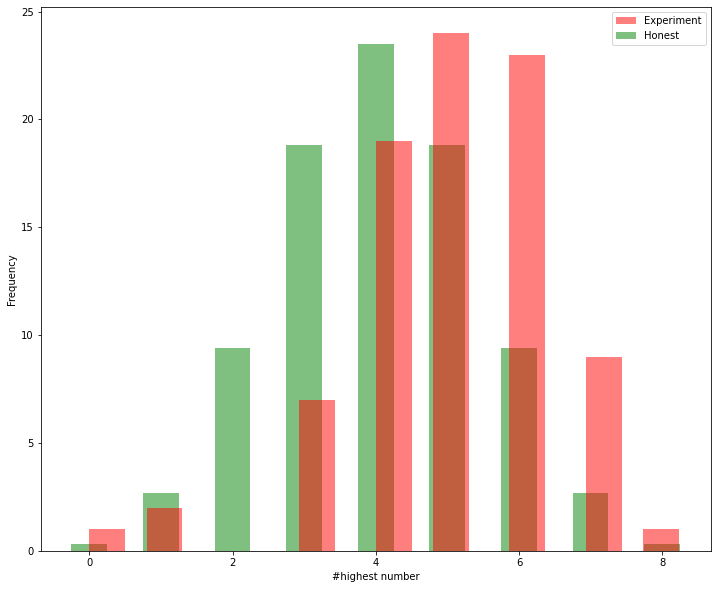

In [13]:
from scipy.stats import binom

n = 8
p = 0.5
sum_list = np.array(all_side_max).sum(axis=0)

r_values = list(range(n + 1))

mean, var = binom.stats(n, p)

dist = [binom.pmf(r, n, p)*len(sum_list) for r in r_values ]


plt.bar(r_values, dist, alpha=0.5, color='green',width=0.5, label = 'Honest')
plt.hist(sum_list, bins=30,alpha=0.5, color='red', width=0.5, label = 'Experiment')
plt.xlabel('#highest number')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [14]:
#one-tailed binom test
import scipy
scipy.stats.binom_test(7, n=8, p=0.5, alternative='greater')

0.03515625

In [15]:
#one-tailed binom test
import scipy
scipy.stats.binom_test(6, n=8, p=0.5, alternative='greater')

0.14453124999999994

## Dynamics Group Foresight and Treatment Foresight

In [16]:
#treatments
round_cat_person_data = (all_data.groupby(['round','categ_person'])['flg_max_num'].sum()/all_data.groupby(['round','categ_person'])['flg_max_num'].count()).reset_index()
#groups
round_cat_num_data = (all_data.groupby(['round','categ_num'])['flg_max_num'].sum()/all_data.groupby(['round','categ_num'])['flg_max_num'].count()).reset_index()


### Treatment Foresight

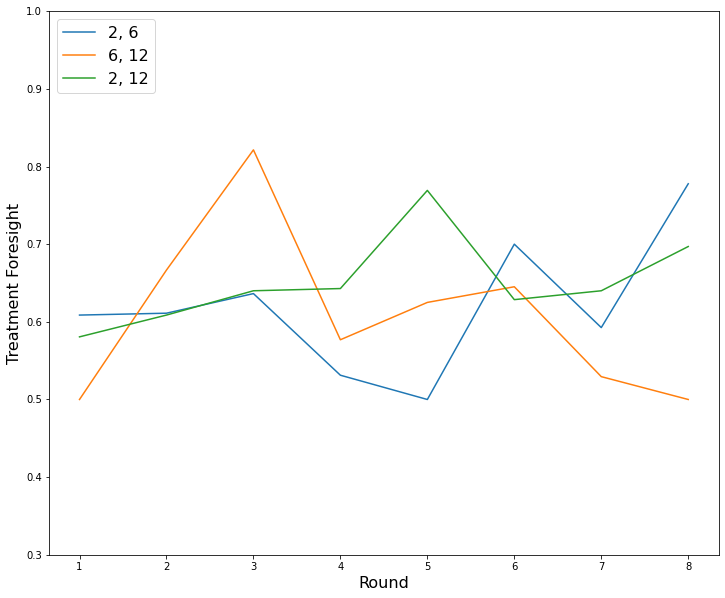

In [17]:
a1 = round_cat_num_data[round_cat_num_data.categ_num == 1].flg_max_num
a2 = round_cat_num_data[round_cat_num_data.categ_num == 2].flg_max_num
a3 = round_cat_num_data[round_cat_num_data.categ_num == 3].flg_max_num

plt.plot(np.arange(1,9), a1, label = '2, 6')
plt.plot(np.arange(1,9), a2, label = '6, 12')
plt.plot(np.arange(1,9), a3, label = '2, 12')
plt.xlabel('Round', size=16)
plt.ylabel('Treatment Foresight', size=16)
plt.ylim(0.3,1)
plt.legend(prop={'size': 16}, loc=2)
plt.show()

In [18]:
#participants in treatments
all_data.groupby(['round','categ_num'])['flg_max_num'].count() 

round  categ_num
1      1            23
       2            32
       3            31
2      1            36
       2            27
       3            23
3      1            33
       2            28
       3            25
4      1            32
       2            26
       3            28
5      1            36
       2            24
       3            26
6      1            20
       2            31
       3            35
7      1            27
       2            34
       3            25
8      1            27
       2            26
       3            33
Name: flg_max_num, dtype: int64

<ipython-input-19-1609c23b2b10>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(values)


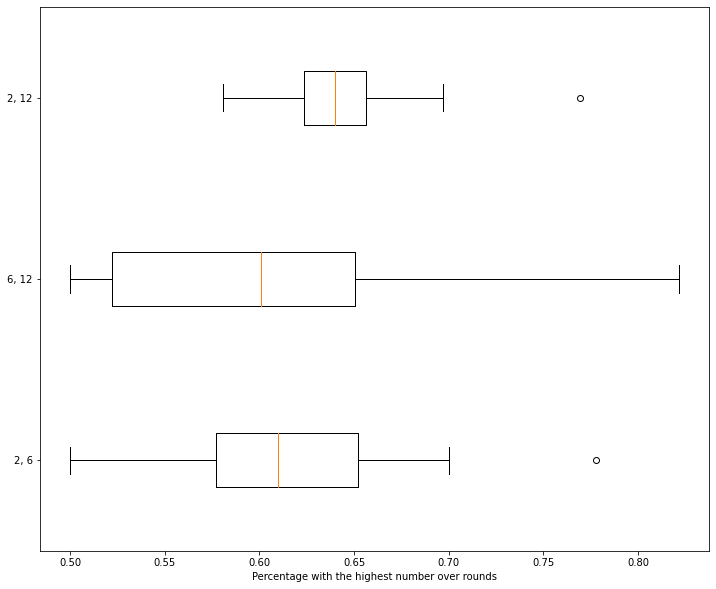

In [19]:
a = [a1,a2,a3]
fig,ax = plt.subplots(1,1)
values = ['2, 6', '6, 12', '2, 12']
ax.set_yticklabels(values)
ax.set_xlabel('Percentage with the highest number over rounds')
ax.boxplot(a, vert=False)
# ax.axvline(0.5, ls='--')
plt.show()

In [20]:
#all participants and participants who choose the highest number
all_data.groupby(['categ_num'])['flg_max_num'].count(), all_data.groupby(['categ_num'])['flg_max_num'].sum()

(categ_num
 1    234
 2    228
 3    226
 Name: flg_max_num, dtype: int64,
 categ_num
 1    143
 2    138
 3    147
 Name: flg_max_num, dtype: int64)

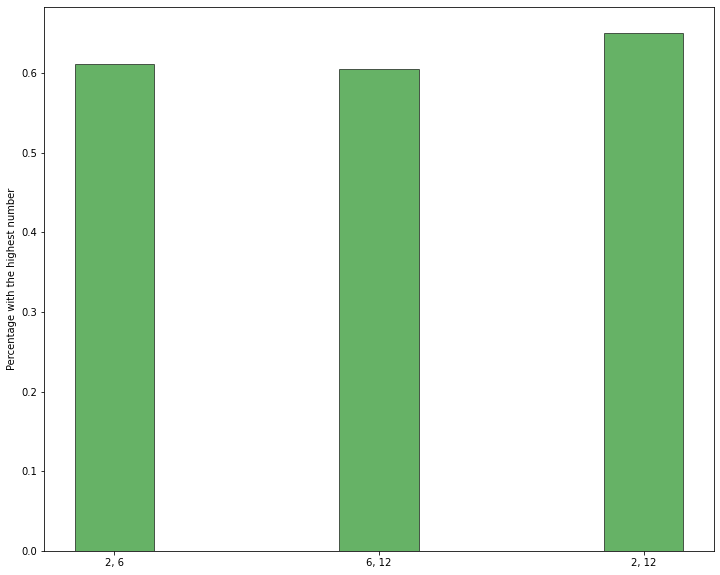

In [21]:
m1 = all_data[(all_data['categ_num']==1)].flg_max_num.mean()
m2 = all_data[(all_data['categ_num']==2)].flg_max_num.mean()
m3 = all_data[(all_data['categ_num']==3)].flg_max_num.mean()

s1 = all_data[(all_data['categ_num']==1)].flg_max_num.std()
s2 = all_data[(all_data['categ_num']==2)].flg_max_num.std()
s3 = all_data[(all_data['categ_num']==3)].flg_max_num.std()


# width of the bars
barWidth = 0.3
 
# Choose the height
bars1 = [m1,m2,m3]
 
# Choose the height of the error bars
yer1 = [s1,s2,s3]
  
# The x position of bars
r1 = np.arange(len(bars1))
 
# Create bars
plt.bar(r1, bars1, width = barWidth, color = 'green', edgecolor = 'black', capsize=7, alpha=0.6) 
  
# general layout
plt.xticks([r for r in range(3)], ['2, 6','6, 12', '2, 12'])
plt.ylabel('Percentage with the highest number')
plt.show()

## Group Foresight

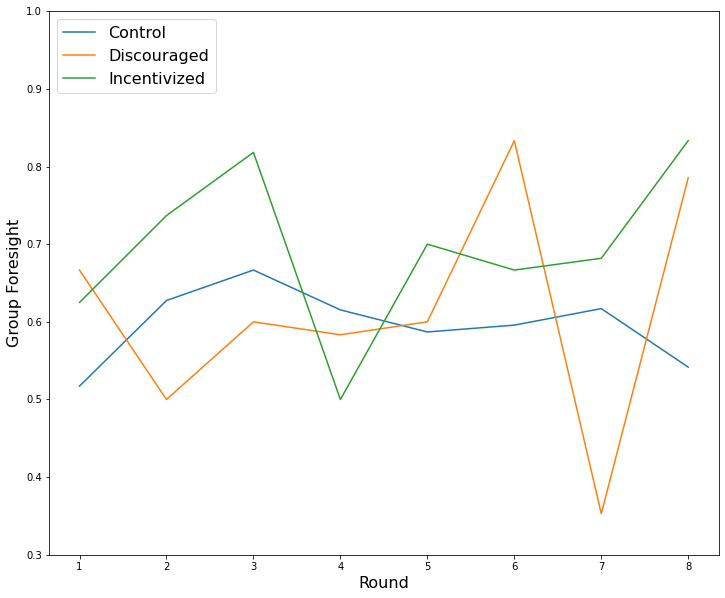

In [37]:
b1 = round_cat_person_data[round_cat_person_data.categ_person == 1].flg_max_num
b2 = round_cat_person_data[round_cat_person_data.categ_person == 2].flg_max_num
b3 = round_cat_person_data[round_cat_person_data.categ_person == 3].flg_max_num

plt.plot(np.arange(1,9), b1, label = 'Control')
plt.plot(np.arange(1,9), b2, label = 'Discouraged')
plt.plot(np.arange(1,9), b3, label = 'Incentivized')

plt.xlabel('Round', size = 16)
plt.ylabel('Group Foresight', size=16)
plt.ylim(0.3,1)
plt.legend(prop={'size': 16}, loc=2)
plt.show()

In [23]:
#most participants have chosen "safe" option
all_data.groupby(['round','categ_person'])['flg_max_num'].count() 

round  categ_person
1      1               58
       2               12
       3               16
2      1               51
       2               16
       3               19
3      1               54
       2               10
       3               22
4      1               52
       2               12
       3               22
5      1               46
       2               20
       3               20
6      1               47
       2               12
       3               27
7      1               47
       2               17
       3               22
8      1               48
       2               14
       3               24
Name: flg_max_num, dtype: int64

<ipython-input-38-4fc7081f9807>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(values)


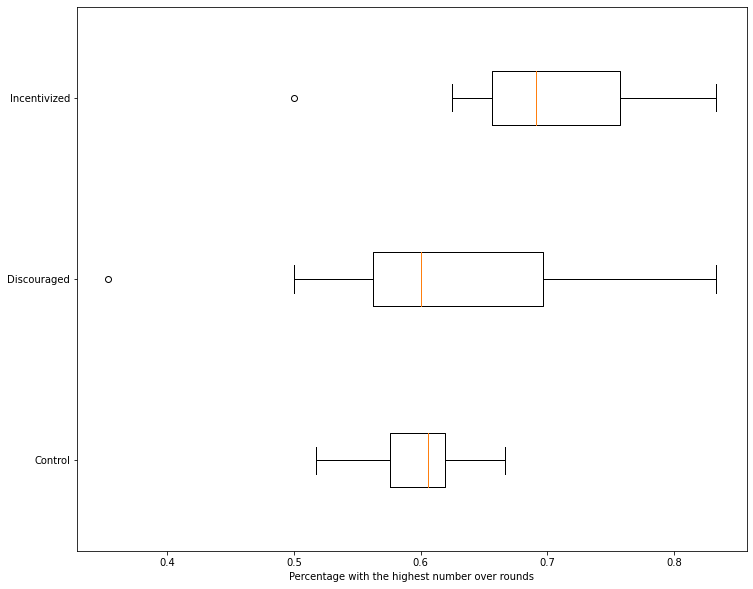

In [38]:
b = [b1,b2,b3]
fig,ax = plt.subplots(1,1)
values = ['Control', 'Discouraged', 'Incentivized']
ax.set_yticklabels(values)
ax.set_xlabel('Percentage with the highest number over rounds')
ax.boxplot(b, vert=False)
# ax.axvline(0.5, ls='--')
plt.show()

In [25]:
#all participants and participants who choose the highest number
all_data.groupby(['categ_person'])['flg_max_num'].count(), all_data.groupby(['categ_person'])['flg_max_num'].sum()

(categ_person
 1    403
 2    113
 3    172
 Name: flg_max_num, dtype: int64,
 categ_person
 1    240
 2     68
 3    120
 Name: flg_max_num, dtype: int64)

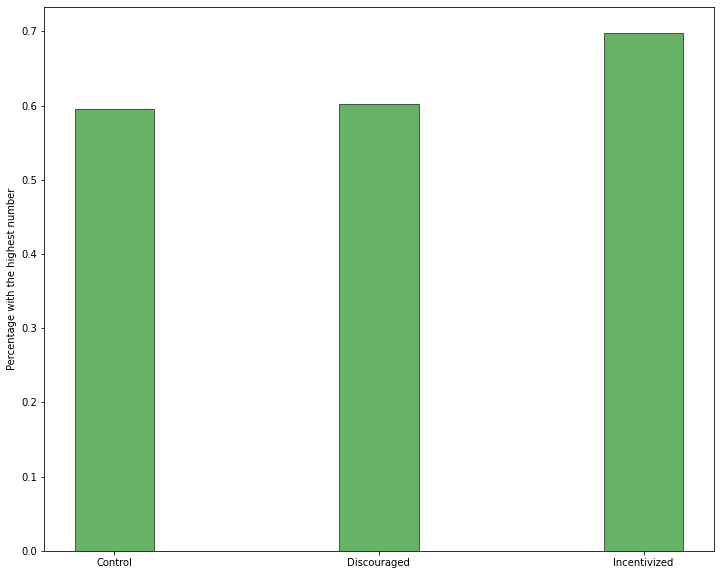

In [39]:
m1 = all_data[(all_data['categ_person']==1)].flg_max_num.mean()
m2 = all_data[(all_data['categ_person']==2)].flg_max_num.mean()
m3 = all_data[(all_data['categ_person']==3)].flg_max_num.mean()

s11 = all_data[(all_data['categ_person']==1)].flg_max_num.std()
s21 = all_data[(all_data['categ_person']==2)].flg_max_num.std()
s31 = all_data[(all_data['categ_person']==3)].flg_max_num.std()


# width of the bars
barWidth = 0.3
 
# Choose the height
bars1 = [m1,m2,m3]
 
# Choose the height of the error bars
yer1 = [s11,s21,s31]
  
# The x position of bars
r1 = np.arange(len(bars1))
 
# Create bars
plt.bar(r1, bars1, width = barWidth, color = 'green', edgecolor = 'black', capsize=7, alpha=0.6) #, yerr=yer1
  
# general layout
plt.xticks([r for r in range(3)], ['Control', 'Discouraged', 'Incentivized'])
plt.ylabel('Percentage with the highest number')
plt.show()

## Bars with Group and Treatment Foresight

In [27]:
#all participants and participants who choose the highest number
all_data.groupby(['categ_person', 'categ_num'])['flg_max_num'].count(),all_data.groupby(['categ_person', 'categ_num'])['flg_max_num'].sum()

(categ_person  categ_num
 1             1            139
               2            117
               3            147
 2             1             44
               2             37
               3             32
 3             1             51
               2             74
               3             47
 Name: flg_max_num, dtype: int64,
 categ_person  categ_num
 1             1            82
               2            71
               3            87
 2             1            23
               2            24
               3            21
 3             1            38
               2            43
               3            39
 Name: flg_max_num, dtype: int64)

In [28]:
m11 = all_data[(all_data['categ_num']==1)&(all_data['categ_person']==1)].flg_max_num.mean()
m21 = all_data[(all_data['categ_num']==2)&(all_data['categ_person']==1)].flg_max_num.mean()
m31 = all_data[(all_data['categ_num']==3)&(all_data['categ_person']==1)].flg_max_num.mean()


m12 = all_data[(all_data['categ_num']==1)&(all_data['categ_person']==2)].flg_max_num.mean()
m22 = all_data[(all_data['categ_num']==2)&(all_data['categ_person']==2)].flg_max_num.mean()
m32 = all_data[(all_data['categ_num']==3)&(all_data['categ_person']==2)].flg_max_num.mean()

m13 = all_data[(all_data['categ_num']==1)&(all_data['categ_person']==3)].flg_max_num.mean()
m23 = all_data[(all_data['categ_num']==2)&(all_data['categ_person']==3)].flg_max_num.mean()
m33 = all_data[(all_data['categ_num']==3)&(all_data['categ_person']==3)].flg_max_num.mean()


s11 = all_data[(all_data['categ_num']==1)&(all_data['categ_person']==1)].flg_max_num.std()
s21 = all_data[(all_data['categ_num']==2)&(all_data['categ_person']==1)].flg_max_num.std()
s31 = all_data[(all_data['categ_num']==3)&(all_data['categ_person']==1)].flg_max_num.std()

s12 = all_data[(all_data['categ_num']==1)&(all_data['categ_person']==2)].flg_max_num.std()
s22 = all_data[(all_data['categ_num']==2)&(all_data['categ_person']==2)].flg_max_num.std()
s32 = all_data[(all_data['categ_num']==3)&(all_data['categ_person']==2)].flg_max_num.std()

s13 = all_data[(all_data['categ_num']==1)&(all_data['categ_person']==3)].flg_max_num.std()
s23 = all_data[(all_data['categ_num']==2)&(all_data['categ_person']==3)].flg_max_num.std()
s33 = all_data[(all_data['categ_num']==3)&(all_data['categ_person']==3)].flg_max_num.std()

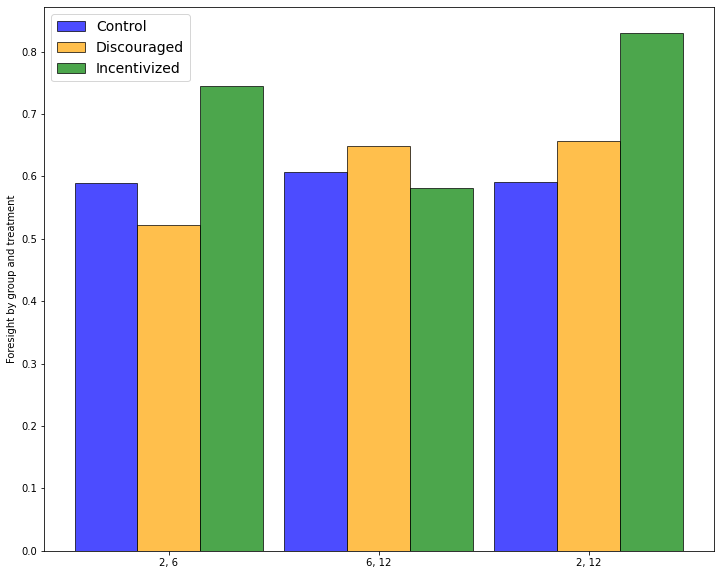

In [40]:
# width of the bars
barWidth = 0.3
 
# Choose the height
bars1 = [m11, m21, m31]

bars2 = [m12, m22, m32]

bars3 = [m13, m23, m33]
 
    
# Choose the height of the error bars

yer1 = [s11, s21, s31]

yer2 = [s12, s22, s32]

yer3 = [s13, s23, s33]
  
    
# The x position of bars

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Create bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Control', alpha=0.7) #yerr=yer1

plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', capsize=7, label='Discouraged', alpha=0.7)

plt.bar(r3, bars3, width = barWidth, color = 'green', edgecolor = 'black', capsize=7, label = 'Incentivized', alpha=0.7)
  
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], ['2, 6', '6, 12', '2, 12'])
plt.legend(prop={'size': 14}, loc=2)
plt.ylabel('Foresight by group and treatment')
plt.show()

# Final data

In [30]:
final_data = all_data.merge(data, on='id', how='left')

In [31]:
final_data.head()

,round,categ_num,categ_person,flg_max_num,id,age,gender,gpa,income,subject_risk,cheat_activity,cheat_disagree,inc,holt_risk,mean_side,mean_cat_person
0,1,2,2,0,b0s88jol,21.0,Male,9.0,10 000 - 20 000 rubles,6.0,3.0,4.0,2,7,0.500,1.75
1,1,2,1,0,fgy4bsys,20.0,Male,6.0,40 000 - 70 000 rubles,3.0,3.0,4.0,4,6,0.500,1.50
2,1,3,1,0,au42r31p,21.0,Male,8.0,20 000 - 40 000 rubles,6.0,5.0,6.0,3,6,0.750,1.00
3,1,1,1,0,dj8u2oej,21.0,Female,8.0,<10 000 rubles,3.0,1.0,10.0,1,6,0.125,1.00
4,1,3,1,1,6yhpp3ae,21.0,Male,7.0,<10 000 rubles,4.0,3.0,7.0,1,4,0.750,1.00


In [32]:
final_data.to_csv('final_data.csv')

# Correlations between features

In [33]:
d=data[['age', 'gender', 'gpa', 'inc']]

d = d.rename(
    {
      'inc':'income',
    
    }
, axis=1)

d['sex'] = d.gender.apply(lambda x: 1 if x =='Male' else 0)
d = d.drop('gender', axis=1)

d['cheat activity'] = data.cheat_activity
d['cheat disagreement'] = data.cheat_disagree

d['subject risk'] = data.subject_risk
d['holt laury risk'] = data.holt_risk

d['average category person'] = data.mean_cat_person
d['Foresight'] = data.mean_side


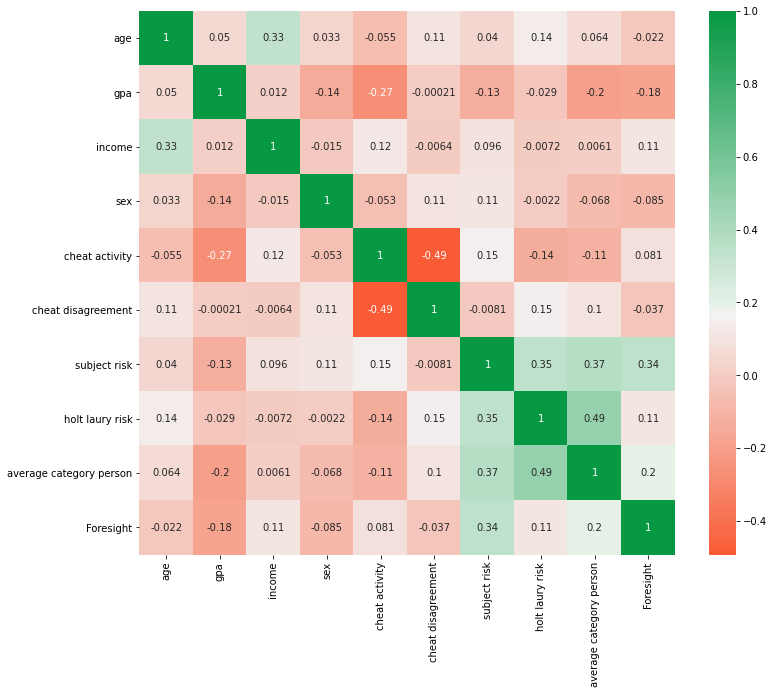

In [34]:
rdgn = sns.diverging_palette(h_neg=15, h_pos=135, s=99, l=55, sep=3, as_cmap=True)
sns.heatmap(d.corr(),annot=True, cmap=rdgn,center=0.17);

In [35]:
data['sex'] = data.gender.apply(lambda x: 1 if x =='Male' else 0)
data = data.drop('gender', axis=1)

In [36]:
data.to_csv('data.csv')